## Data Exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
df = pd.read_csv('dataset\\train.tsv', delimiter='\t')
df.head()

,title,is_fake
0,Москвичу Владимиру Клутину пришёл счёт за вмеш...,1
1,Агент Кокорина назвал езду по встречке житейск...,0
2,Госдума рассмотрит возможность введения секрет...,1
3,ФАС заблокировала поставку скоростных трамваев...,0
4,Против Навального завели дело о недоносительст...,1


In [3]:
print('Размер train выборки:', df.shape)

Размер train выборки: (5758, 2)


Дизбаланса нет, уже отлично

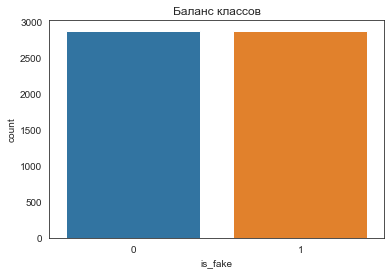

In [4]:
sns.set_style('white')
sns.countplot(x='is_fake', data=df).set_title('Баланс классов')
plt.show()

## Data Preprocessing

In [5]:
import os
import requests


url_stopwords_ru = "https://raw.githubusercontent.com/stopwords-iso/stopwords-ru/master/stopwords-ru.txt"


def get_text(url, encoding='utf-8', to_lower=True):
    url = str(url)
    if url.startswith('http'):
        r = requests.get(url)
        if not r.ok:
            r.raise_for_status()
        return r.text.lower() if to_lower else r.text
    elif os.path.exists(url):
        with open(url, encoding=encoding) as f:
            return f.read().lower() if to_lower else f.read()
    else:
        raise Exception('parameter [url] can be either URL or a filename')

In [7]:
# Получаем стоп слова, которые мы удалим из заголовков
stopwords_ru = get_text(url_stopwords_ru).splitlines()
print(stopwords_ru[-5:])

['этому', 'этот', 'эту', 'я', 'являюсь']


In [8]:
from nltk import sent_tokenize, regexp_tokenize
import pymorphy2


def normalize_tokens(tokens):
    morph = pymorphy2.MorphAnalyzer()
    return [morph.parse(tok)[0].normal_form for tok in tokens]


def remove_stopwords(tokens, stopwords=None, min_length=4):
    if stopwords is None:
        return tokens
    stopwords = set(stopwords)
    tokens = [tok for tok in tokens
              if tok not in stopwords and len(tok) >= min_length]
    return tokens


def tokenize_n_lemmatize(text, stopwords=None, normalize=True, regexp=r'(?u)\b\w{4,}\b'):
    words = [w for sent in sent_tokenize(text)
             for w in regexp_tokenize(sent, regexp)]
    if normalize:
        words = normalize_tokens(words)
    if stopwords is not None:
        words = remove_stopwords(words, stopwords)
    return words

Небольшой тест работоспособности

In [9]:
print('Сырой вид:', df.loc[0, 'title'])
words = tokenize_n_lemmatize(df.loc[0, 'title'], stopwords=stopwords_ru)
print('Вид после преобразования:', words)

Сырой вид: Москвичу Владимиру Клутину пришёл счёт за вмешательство в американские выборы
Вид после преобразования: ['москвич', 'владимир', 'клутина', 'прийти', 'счёт', 'вмешательство', 'американский', 'выборы']


In [12]:
def tokenize_n_lemmatize_sents(texts, stopwords=None, normalize=True, regexp=r'(?u)\b\w{4,}\b'):
    sents = [tokenize_n_lemmatize(sent, stopwords=stopwords,
                                  normalize=normalize, regexp=regexp)
             for sent in texts]
    
    return sents

sents = tokenize_n_lemmatize_sents(df['title'].values, stopwords=stopwords_ru)
print(sents[-1])

['бывший', 'тренер', 'локомотив', 'возглавить', 'нальчикский', 'спартак']


In [13]:
from sklearn.feature_extraction.text import CountVectorizer


vectorizer = CountVectorizer()
X = vectorizer.fit_transform([' '.join(sentence) for sentence in sents])

vectorizer.get_feature_names_out()

array(['1000', '1079', '1200', ..., 'ящик', 'ёлка', 'ёршик'], dtype=object)

In [14]:
X.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [15]:
print(X.shape)

(5758, 10105)


In [16]:
# Проверка, что все сработало как надо
vectorizer.get_feature_names_out()[X.toarray()[0].astype(np.bool8)]

array(['американский', 'владимир', 'вмешательство', 'выборы', 'клутина',
       'москвич', 'прийти', 'счёт'], dtype=object)

## Save the Data

In [17]:
new_df = pd.DataFrame(columns=vectorizer.get_feature_names_out(),
                      data=X.toarray())

print(new_df.head())

   1000  1079  1200  1250  13000  1440  1500  1700  1812  1886  ...  ярош  \
0     0     0     0     0      0     0     0     0     0     0  ...     0   
1     0     0     0     0      0     0     0     0     0     0  ...     0   
2     0     0     0     0      0     0     0     0     0     0  ...     0   
3     0     0     0     0      0     0     0     0     0     0  ...     0   
4     0     0     0     0      0     0     0     0     0     0  ...     0   

   ярцев  ясный  ястреб  яхта  яценюк  яшин  ящик  ёлка  ёршик  
0      0      0       0     0       0     0     0     0      0  
1      0      0       0     0       0     0     0     0      0  
2      0      0       0     0       0     0     0     0      0  
3      0      0       0     0       0     0     0     0      0  
4      0      0       0     0       0     0     0     0      0  

[5 rows x 10105 columns]


In [18]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5758 entries, 0 to 5757
Columns: 10105 entries, 1000 to ёршик
dtypes: int64(10105)
memory usage: 443.9 MB


Преобразуем тип данных в bool, для экономии места на диске

In [19]:
new_df = new_df.astype(bool)
new_df.head()

,1000,1079,1200,1250,13000,1440,1500,1700,1812,1886,...,ярош,ярцев,ясный,ястреб,яхта,яценюк,яшин,ящик,ёлка,ёршик
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [20]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5758 entries, 0 to 5757
Columns: 10105 entries, 1000 to ёршик
dtypes: bool(10105)
memory usage: 55.5 MB


In [24]:
new_df = pd.merge(new_df, df, how='inner', left_index=True, right_index=True)
new_df.head()

,1000,1079,1200,1250,13000,1440,1500,1700,1812,1886,...,ясный,ястреб,яхта,яценюк,яшин,ящик,ёлка,ёршик,title,is_fake
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,Москвичу Владимиру Клутину пришёл счёт за вмеш...,1
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,Агент Кокорина назвал езду по встречке житейск...,0
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,Госдума рассмотрит возможность введения секрет...,1
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,ФАС заблокировала поставку скоростных трамваев...,0
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,Против Навального завели дело о недоносительст...,1


In [25]:
new_df.drop(['title'], axis=1, inplace=True)

In [26]:
new_df.to_csv('new data/new_df_train.csv', index=False)

## Same for Test

In [27]:
df_test = pd.read_csv('dataset\\test.tsv', delimiter='\t')
df_test.head()

,title,is_fake
0,Роскомнадзор представил реестр сочетаний цвето...,0
1,Ночью под Минском на президентской горе Белара...,0
2,Бывший спичрайтер Юрия Лозы рассказал о трудно...,0
3,"Сельская церковь, собравшая рекордно низкое ко...",0
4,Акции Google рухнули после объявления о переза...,0


In [28]:
df_test.shape

(1000, 2)

In [29]:
sents = tokenize_n_lemmatize_sents(df_test['title'].values, stopwords=stopwords_ru)
X_test = vectorizer.transform([' '.join(sentence) for sentence in sents])
X_test.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [30]:
new_df = pd.DataFrame(columns=vectorizer.get_feature_names_out(),
                      data=X_test.toarray())
new_df = new_df.astype(bool)
new_df = pd.merge(new_df, df_test, how='inner', left_index=True, right_index=True)
new_df.drop(['title'], axis=1, inplace=True)

new_df.head()

,1000,1079,1200,1250,13000,1440,1500,1700,1812,1886,...,ярцев,ясный,ястреб,яхта,яценюк,яшин,ящик,ёлка,ёршик,is_fake
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0


In [31]:
new_df.to_csv('new data/new_df_test.csv', index=False)